In [32]:
import pandas as pd
import numpy as np

covidData = pd.read_csv('../data/interim/covidData.csv', index_col=0)
rel_census_data = pd.read_csv('../data/interim/rel_census_data.csv', index_col=0)
rent_clean = pd.read_csv('../data/interim/rent_clean.csv', index_col=0)
inv_clean = pd.read_csv('../data/interim/inv_clean.csv', index_col=0)
combined_data = pd.read_csv('../data/processed/combined_data.csv', index_col=0)

## Exploratory Data Analysis

#### Plotting Inventory and Rent

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

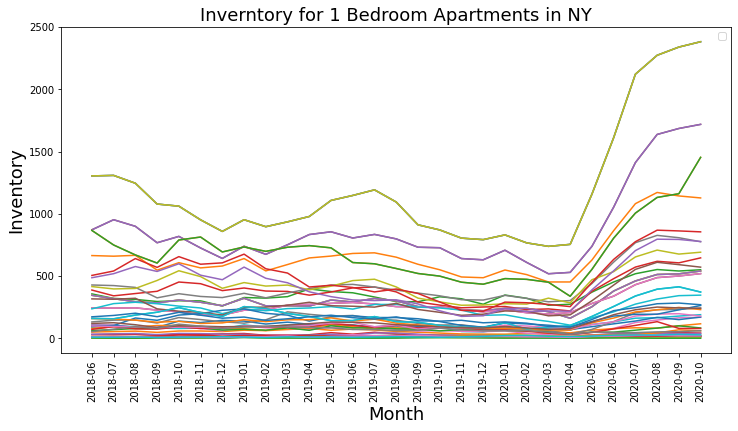

In [34]:
view = inv_clean[inv_clean['bd']==1].sample(n = 50) 
plt.figure(figsize=(12,6))

for row in range(len(view)):
    sns.lineplot(x=view.columns[2:],y=view.iloc[row,2:])
    plt.title('Inverntory for 1 Bedroom Apartments in NY',size=18)
    plt.xlabel('Month',size=18)
    plt.ylabel('Inventory',size=18)
    plt.xticks(view.columns[2:], view.columns[2:], rotation='vertical')

plt.legend('')

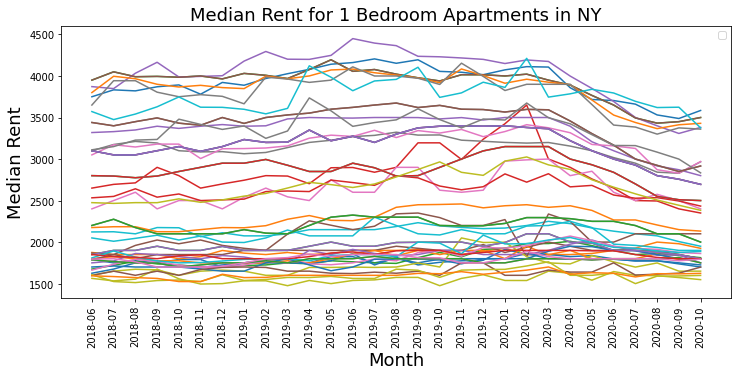

In [35]:
view=rent_clean[rent_clean['bd']==1].sample(50)
plt.figure(figsize=(12,5))
for row in range(len(view)):
  sns.lineplot(x=view.columns[2:],y=view.iloc[row,2:])
  plt.title('Median Rent for 1 Bedroom Apartments in NY', size=18)
  plt.xlabel('Month',size=18)
  plt.ylabel('Median Rent',size=18)
  plt.xticks(view.columns[2:], view.columns[2:], rotation='vertical')
  # plt.legend(bbox_to_anchor=(1.05, 1))

plt.legend('')

#### Ridge Regression for October 2020 Rent Using Prev. Months

Use simple Ridge regression to calculate coefs to guide feature selection.

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_oct=rent_clean.iloc[:,2:-1]
Y_oct=rent_clean.iloc[:,-1:]

X_train, X_test, Y_train, Y_test = train_test_split(X_oct, Y_oct, test_size=0.20)

ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train,Y_train)
ridge1.coef_

array([[-0.01888178, -0.11397892,  0.07888632, -0.18049754,  0.18308559,
         0.03657101,  0.06626541, -0.07646356, -0.01033239,  0.02386728,
         0.1615735 , -0.16068087,  0.09327976, -0.05827757,  0.20999513,
        -0.3395311 ,  0.25887937, -0.07667896,  0.0089631 , -0.05811147,
         0.04047793, -0.04595767,  0.04465851, -0.03678289,  0.11025873,
        -0.24391881,  0.24259001,  0.86165471]])

In [37]:
X_Jan=rent_clean.iloc[:,2:-10]
Y_Jan=rent_clean.iloc[:,-10:-9]

X_train, X_test, Y_train, Y_test = train_test_split(X_oct, Y_oct, test_size=0.20)

ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train,Y_train)
ridge1.coef_

array([[-0.02132965, -0.12353901,  0.09075175, -0.1120242 ,  0.08301868,
         0.03502467,  0.1024686 , -0.077576  , -0.03079993,  0.03182011,
         0.08677767, -0.09179855,  0.07144561,  0.03157234,  0.2442114 ,
        -0.39225921,  0.17667032,  0.0570382 , -0.07710673, -0.10299404,
         0.03005902,  0.04810576,  0.02249532, -0.07520501,  0.07554014,
        -0.17409555,  0.29478137,  0.79543395]])

#### Collinearity

Calculate VIF for features.

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = combined_data.iloc[:,1:]

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
vif_data = vif_data.sort_values(by=['VIF'])
#pd.set_option('display.max_rows', None) #VIF above 5 is deemed as high collinearity


print(vif_data)

C:\Users\Arthur\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                              feature       VIF
1                                      prev_inventory  2.421355
45  median_year_structure_built__housing_units_med...  2.612601
5                      covid_rate_of_increase_prev_mo  2.713723
2                                    covid_%_positive  3.196076
0                                     prev_month_rent  3.695989
..                                                ...       ...
26             sex_by_age_total_population_total_male       inf
27           sex_by_age_total_population_total_female       inf
12                                            month_7       inf
10                                            month_5       inf
30                       race__total_population_total       inf

[62 rows x 2 columns]


Conduct PCA and simple linear regression to find # of useful non-collinear features.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [40]:
X = combined_data.iloc[:,1:]
Y = combined_data.iloc[:,0]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [41]:
pca = PCA()
pca.fit(X_scaled)
sum(pca.explained_variance_ratio_[:40]) 
#5 components explain ~57.2% of variance
#15 components explain ~80.9% of variance
#30 components explain ~97.5% of variance
#40 components explains ~99.7% of variance

0.9946770008681352

In [42]:
pca.set_params(n_components=40)
pca.fit(X_scaled)
X_pc = pca.transform(X_scaled)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split( X_pc, Y, test_size=0.20)

lr = LinearRegression().fit(X_train, Y_train)
print("MSE: ", mean_squared_error(Y_test,lr.predict(X_test)))
print("Mean Error (Magnitude): ", np.sqrt(mean_squared_error(Y_test,lr.predict(X_test))))

MSE:  61699.20034235075
Mean Error (Magnitude):  248.3932373120306


In [44]:
feature_coefs = pd.DataFrame(zip(pd.DataFrame(X_train).columns.tolist(), lr.coef_.tolist()),columns=['feature','coef'])
print("Feature Coefs: ")
print(feature_coefs.sort_values(by='coef',ascending=False).head(10))

Feature Coefs: 
    feature        coef
32       32  996.848669
35       35  854.897574
6         6  630.515646
5         5  456.095958
7         7  404.062736
1         1  291.108515
8         8  238.543589
25       25  218.528056
0         0  205.452374
37       37  117.235237


In [45]:
top_principal_components = feature_coefs.sort_values(by='coef',ascending=False).head(3)['feature'].values

for pc in top_principal_components:
    print("")
    print("top 5 features in principal components {number}: ".format(number=pc))
    print(pd.DataFrame(zip(X.columns.to_list(), pca.components_[pc])).sort_values(by=1,ascending=False).head(5))


top 5 features in principal components 32: 
                                                    0         1
0                                     prev_month_rent  0.546108
1                                      prev_inventory  0.260663
21                                            bd__0.0  0.194795
51  median_gross_rent_as_a_percentage_of_household...  0.164139
37  sex_of_workers_by_means_of_transportation_to_w...  0.150510

top 5 features in principal components 35: 
                                                    0         1
46  lower_contract_rent_quartile_(dollars)__renter...  0.500165
0                                     prev_month_rent  0.475272
38  sex_of_workers_by_means_of_transportation_to_w...  0.268539
1                                      prev_inventory  0.170845
21                                            bd__0.0  0.167721

top 5 features in principal components 6: 
                         0         1
24                 bd__3.0  0.490008
18               year_20